The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [ ]:
# TODO : import the dataset

# Import the dataset
df = pd.read_csv('/Users/margotiamanova/Desktop/DI-Bootcamp/Week7/Day3/ExerciseXP/AB_Test_Results.csv')  


   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0


In [6]:
# TODO : take a quick look at the data
print(df.head())  # Display the first 5 rows of the dataset
df.shape
df.info()
df.describe()

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [8]:
df.isnull().sum() # Check for missing values

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Let's see if there are users who have two A/B test groups

In [11]:
# TODO : Look at the distribution of the number of unique groups for each user

# Group by USER_ID and count the number of unique VARIANT_NAME values for each user
unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

# Display the distribution
print(unique_groups_per_user.value_counts())  # Count how many users belong to each unique group count


VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


In [13]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

# Calculate the relative distribution
relative_distribution = unique_groups_per_user.value_counts(normalize=True) * 100  # Convert to percentages

# Display the relative distribution
print(relative_distribution)

VARIANT_NAME
1    75.632511
2    24.367489
Name: proportion, dtype: float64


75.63% of users belong to 1 unique group
24.37% of users belong to 2 unique groups

What can you observe ? Should we exclude these users ? Why ?
Yes, users who interacted with both groups should generally be excluded from the analysis.Users exposed to both groups may have biased behavior, as their experience is influenced by both the control and variant conditions. This can distort the results of the A/B test.

In [16]:
# TODO : users have 1 A/B test group ?

# TODO : Take only these users


# Identify users who belong to only 1 A/B test group
users_with_1_variant = unique_groups_per_user[unique_groups_per_user == 1].index

# Filter the dataset to include only these users
df_filtered = df[df['USER_ID'].isin(users_with_1_variant)]

# Verify the result
print(f"Number of users with 1 A/B test group: {df_filtered['USER_ID'].nunique()}")
print(f"Total rows in filtered dataset: {len(df_filtered)}")


Number of users with 1 A/B test group: 4783
Total rows in filtered dataset: 6070


In [20]:
# TODO : Leave only records with users with the 1st ab test group

# TODO : Check that the number of users matches what it was before the exception

expected_users_count = len(users_with_1_variant)  # Number of users with 1 A/B test group
actual_users_count = df_filtered['USER_ID'].nunique()

if expected_users_count == actual_users_count:
    print(" Filtering is correct")
else:
    print(f"Mismatch in user count! Expected: {expected_users_count}, Actual: {actual_users_count}")

 Filtering is correct


Let's see how the data is distributed

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/1049511242.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')


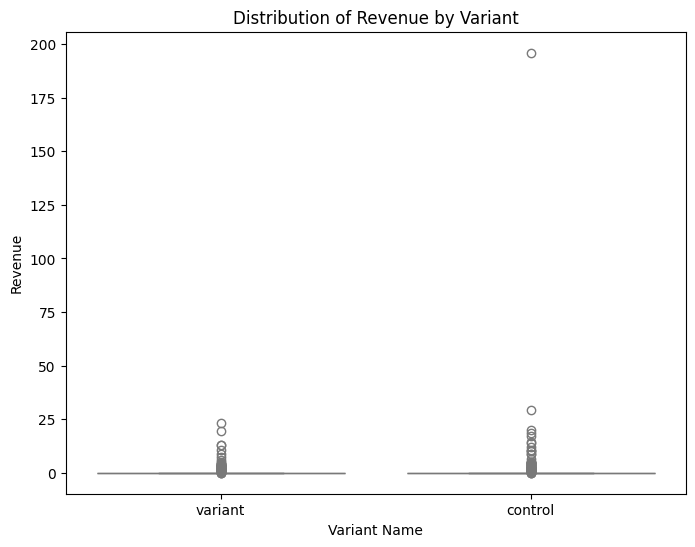

In [21]:
# TODO : Check how the data is distributed using a box plot

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')

# Add titles and labels
plt.title('Distribution of Revenue by Variant')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')

# Display the plot
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [22]:
# TODO : Sort these revenue values in descending order

sorted_revenue = df_filtered.sort_values(by='REVENUE', ascending=False)

# Display the sorted DataFrame
print(sorted_revenue.head())  # Show the top 5 rows

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
2482     7356      variant    23.04
6412     1053      control    20.07
5217     3684      variant    19.47


In [23]:
sorted_revenue.to_csv('sorted_revenue.csv', index=False)

In [24]:
# TODO : See if user 3342 had other events with a strong outlier
# Filter the dataset for user 3342
user_3342_data = df_filtered[df_filtered['USER_ID'] == 3342]

# Display the user's data
print(user_3342_data)

# Check if the user's revenue contains outliers using IQR
Q1 = df_filtered['REVENUE'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df_filtered['REVENUE'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check if the user's revenue values are outliers
user_3342_outliers = user_3342_data[(user_3342_data['REVENUE'] < lower_bound) | (user_3342_data['REVENUE'] > upper_bound)]

# Display the outliers
print("Outliers for user 3342:")
print(user_3342_outliers)

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
Outliers for user 3342:
      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01


The REVENUE value of 196.01 for user 3342 is considered an outlier because it exceeds the upper boundary calculated using the Interquartile Range (IQR).

We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [25]:
# Remove the outlier for user 3342
df_filtered = df_filtered[df_filtered['REVENUE'] != 196.01]

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/2126653207.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')


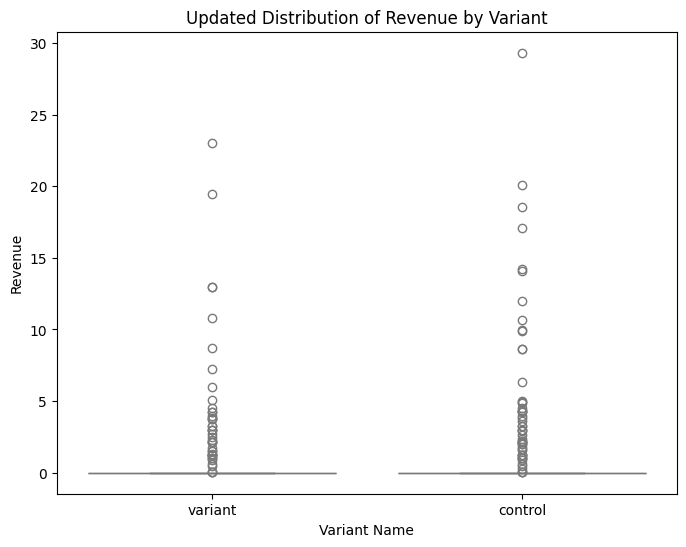

In [59]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.


plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')
plt.title('Updated Distribution of Revenue by Variant')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')
plt.show()


What can you say about the users and their purchases ?

In [60]:
# TODO : Check if there are users who have records with zero and positive revenue


users_with_zero_and_positive_revenue = df_filtered.groupby('USER_ID')['REVENUE'].apply(
    lambda x: (x == 0).any() and (x > 0).any()
)

# Filter users who meet the condition
users_with_both = users_with_zero_and_positive_revenue[users_with_zero_and_positive_revenue].index

# Display the result
print(f"Number of users with both zero and positive revenue: {len(users_with_both)}")
print("Users with both zero and positive revenue:")
print(users_with_both)


Number of users with both zero and positive revenue: 37
Users with both zero and positive revenue:
Index([ 124,  169,  282,  443,  487,  708,  868, 1035, 1053, 1339, 1883, 1939,
       2166, 2181, 3326, 3331, 3699, 3797, 4113, 4858, 4918, 5134, 5597, 5900,
       6207, 6271, 6429, 7613, 7930, 8020, 8536, 8583, 8886, 8920, 8927, 9766,
       9928],
      dtype='int64', name='USER_ID')


Can a user have records with both zero and positive revenue ?
Yes, this could happen if the records represent user visits to the service, and not all visits result in revenue.

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.



In [64]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

df_filtered = df_filtered.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

([<matplotlib.axis.XTick at 0x123295730>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

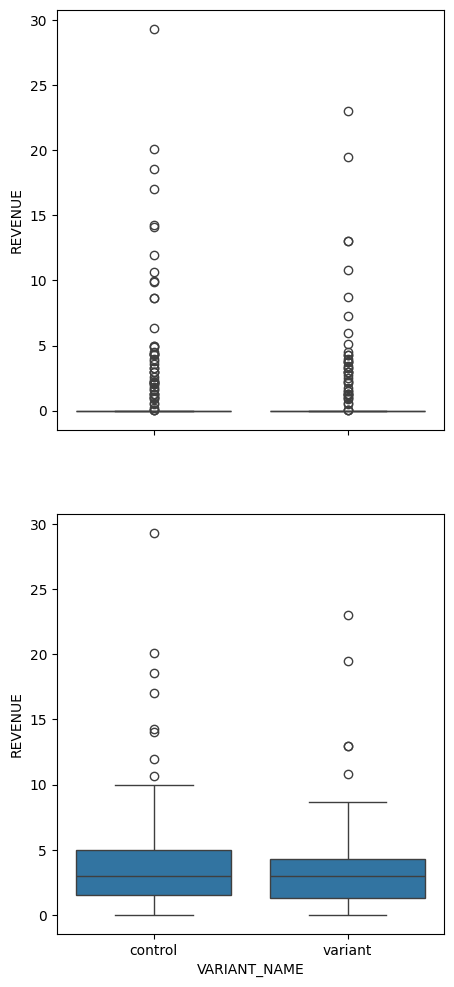

In [65]:
# TODO : Visualize the resulting distribution of the data again.

f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df_filtered)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df_filtered[df_filtered['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [66]:
# TODO : get metrics by groups
metric_stat = df_filtered.groupby(by='VARIANT_NAME').agg({
    'USER_ID': 'nunique',
    'REVENUE': ['sum', 'mean', 'median', 'count']
})

# TODO : create two additional metrics to see relative changes
orders_per_user = metric_stat[('REVENUE', 'count')] / metric_stat[('USER_ID', 'nunique')]
revenue_per_user = metric_stat[('REVENUE', 'sum')] / metric_stat[('USER_ID', 'nunique')]
# TODO : add them to the rest of the metrics in a separate group
metric_stat[('per_user', 'orders')] = orders_per_user
metric_stat[('per_user', 'revenue')] = revenue_per_user


In [67]:
# Display results
print(metric_stat)

             USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [71]:
# TODO : get metrics by groups
paid_users = df_filtered[df_filtered.REVENUE != 0]

# Group by VARIANT_NAME and calculate statistics
paid_stat = paid_users.groupby('VARIANT_NAME').agg(
    unique_users=('USER_ID', 'nunique'),
    total_revenue=('REVENUE', 'sum'),
    avg_revenue=('REVENUE', 'mean'),
    median_revenue=('REVENUE', 'median'),
    total_orders=('REVENUE', 'count')
)

# TODO : create two additional metrics to see relative changes
paid_stat['orders_per_user'] = paid_stat['total_orders'] / paid_stat['unique_users']
paid_stat['revenue_per_user'] = paid_stat['total_revenue'] / paid_stat['unique_users']

# TODO : add them to the rest of the metrics in a separate group
# Display results
print(paid_stat)

              unique_users  total_revenue  avg_revenue  median_revenue  \
VARIANT_NAME                                                             
control                 53         274.55     5.180189            2.99   
variant                 42         179.32     4.269524            2.97   

              total_orders  orders_per_user  revenue_per_user  
VARIANT_NAME                                                   
control                 53              1.0          5.180189  
variant                 42              1.0          4.269524  


Let's look at the distributions of all and only paying users

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

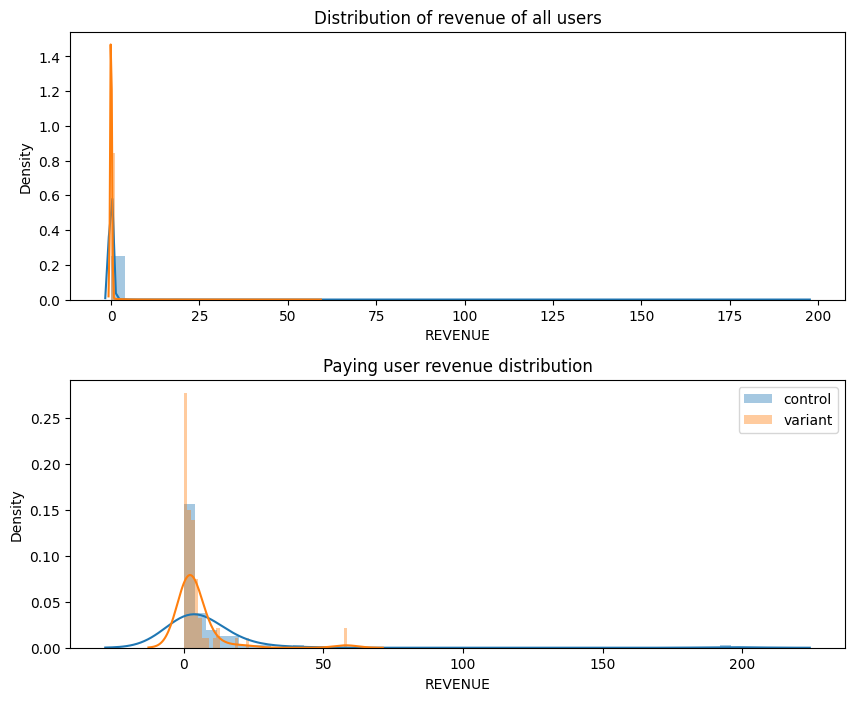

In [72]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [75]:
# TODO : Use the Shapiro-Wilk criterion to confirm it


# Perform the Shapiro-Wilk test for the 'variant' group
stat, p_value = shapiro(df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'])

# Display the results
print(f"Shapiro-Wilk Test for Variant Group:")
print(f"Test Statistic = {stat}, P-value = {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The revenue data for the variant group is NOT normally distributed (reject H0).")
else:
    print("The revenue data for the variant group is normally distributed (fail to reject H0).")

Shapiro-Wilk Test for Variant Group:
Test Statistic = 0.06145986897942335, P-value = 9.962810723092505e-76
The revenue data for the variant group is NOT normally distributed (reject H0).


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [76]:
(df['REVENUE'] == 0).value_counts()

REVENUE
True     9848
False     152
Name: count, dtype: int64

In [78]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test


# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(
    df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'],
    df_filtered.loc[df_filtered.VARIANT_NAME == 'control', 'REVENUE']
)

# Display the results
print(f"Mann-Whitney U Test Statistic: {u_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference between the variant and control groups (reject H0).")
else:
    print("There is no significant difference between the variant and control groups (fail to reject H0).")

Mann-Whitney U Test Statistic: 2845109.0
P-value: 0.24799555106821947
There is no significant difference between the variant and control groups (fail to reject H0).


In [79]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

# Filter the dataset to include only paying users (REVENUE > 0)
paying_users_variant = df_filtered.loc[(df_filtered.VARIANT_NAME == 'variant') & (df_filtered.REVENUE > 0), 'REVENUE']
paying_users_control = df_filtered.loc[(df_filtered.VARIANT_NAME == 'control') & (df_filtered.REVENUE > 0), 'REVENUE']

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(paying_users_variant, paying_users_control)

# Display the results
print(f"Mann-Whitney U Test Statistic: {u_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference between the paying users in the variant and control groups (reject H0).")
else:
    print("There is no significant difference between the paying users in the variant and control groups (fail to reject H0).")

Mann-Whitney U Test Statistic: 1029.0
P-value: 0.5314192217084708
There is no significant difference between the paying users in the variant and control groups (fail to reject H0).


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [80]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [82]:
# TODO : Generate samples for all users
control = get_bootstrap_samples(df_filtered.loc[df_filtered.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df_filtered.loc[df_filtered.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)


In [83]:
# TODO : Generate samples for only paying users
conyt_only_paid = get_bootstrap_samples(df_filtered.loc[(df.VARIANT_NAME == 'control') & (df_filtered.REVENUE > 0), 'REVENUE'].values, 10000)
variant_only_paid = get_bootstrap_samples(df_filtered.loc[(df.VARIANT_NAME == 'variant') & (df_filtered.REVENUE > 0), 'REVENUE'].values, 10000)


Let's look at the distribution of means in the ab test groups

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/2240544031.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/2240544031.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

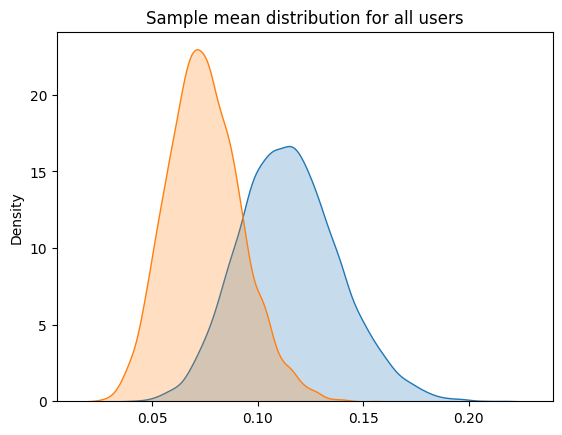

In [84]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/739164507.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(conyt_only_paid, axis=1), shade=True, label='control')
/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/739164507.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_only_paid, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

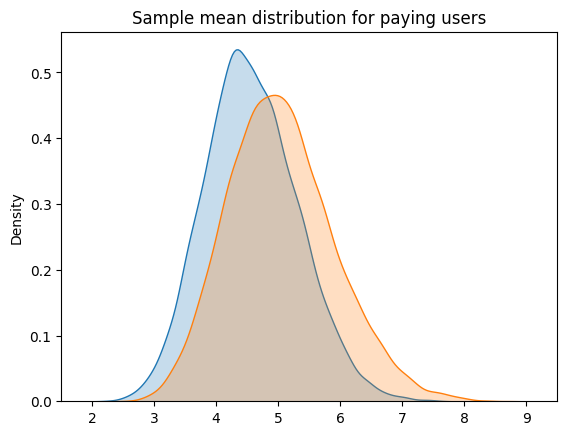

In [85]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(conyt_only_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_only_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [89]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


IndexError: list index out of range

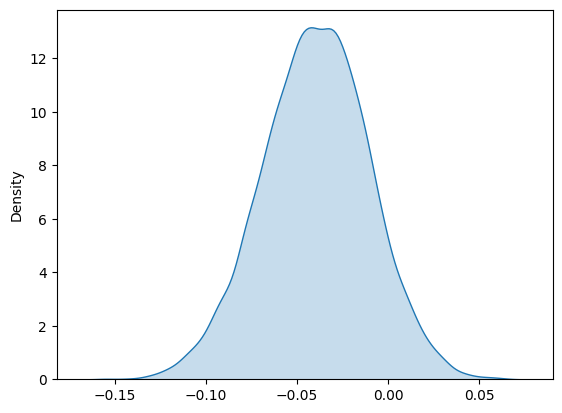

In [90]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

/var/folders/hz/4wr_d_nj47d_tw5jgy2y69lc0000gn/T/ipykernel_15782/4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


IndexError: list index out of range

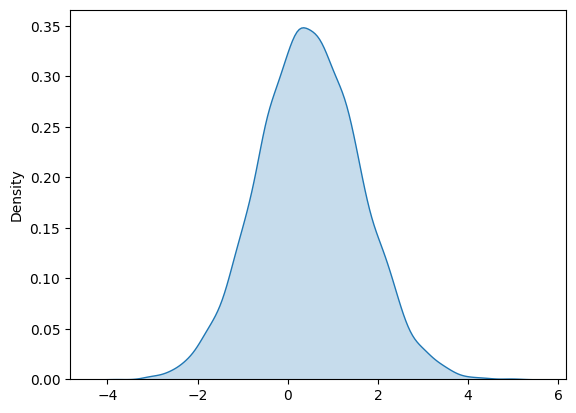

In [91]:
plot_distribution_and_stat_intervals(np.mean(variant_only_paid, axis=1),
                                     np.mean(conyt_only_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
